In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.cuda.is_available()

import time

from torch import nn
from torch import optim
import os
from scipy import io
import pickle
device='cuda'
torch.set_default_tensor_type(torch.FloatTensor)

#from matplotlib import cm
import torchvision


import sys
#inp = int(float(sys.argv[1])-1)
inp=0

# In[2]:




/home/luca/anaconda3/lib/python3.11/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789121465/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
class Data_Manager(nn.Module):
    
    def __init__(self,tr_prc=0.8,Dataset=1, Black_and_White=False):
        super().__init__()

        if Dataset==1:
        
            self.Y=torch.tensor(np.load('../../Robot Self Dataset New/data_hands_closer/states.npy').astype("float32"),device='cpu').to(torch.float16)
            self.A=torch.tensor(np.load('../../Robot Self Dataset New/data_hands_closer/actions.npy').astype("float32"),device='cpu').to(torch.float16)
            
            N_files=10
            self.X=[]
            self.L=[]
            
            for n in range(0,N_files):
    
                title_file='../../Robot Self Dataset New/data_hands_closer/images-'+str(n)+'.npz'
                
                Image=np.load(title_file)
                
                ## mean Converts to black and white
                #self.X.append( torch.mean(torch.tensor(Image['arr_0'][1,...]).to(torch.float16),3,keepdim=True) )
                self.X.append( torch.tensor(Image['arr_0'][1,...]).to(torch.uint8) )

                title_file='../../Robot Self Dataset New/data_hands_closer/labels-'+str(n)+'.npz'
                Labels=np.load(title_file)

                if n>=int(tr_prc*10):
                    self.L.append( (torch.tensor(Labels['arr_0'])[1,:,:,:,1,:]).unsqueeze(-2).to(torch.uint8) )

            self.X=torch.stack(self.X,0).reshape([-1, self.X[0].size()[1], self.X[0].size()[2], self.X[0].size()[3], self.X[0].size()[4] ])
            self.X=self.X.permute(0,3,1,2,4)
            
            self.N_seq=self.X.size()[0]
            self.N_tr=int(tr_prc*self.N_seq)
            self.N_val=int( (self.N_seq-self.N_tr)/2 )
            
                        
            self.L=torch.stack(self.L,0).reshape([-1, self.L[0].size()[1], self.L[0].size()[2], self.L[0].size()[3], self.L[0].size()[4] ])
            self.L=self.L.permute(0,3,1,2,4)

            
            

        if Dataset==2:

            self.Y=torch.tensor(np.load('../../Data_Tiny_Catch/data_1000/states.npy')).to(torch.float16)
            self.A=torch.tensor(np.load('../../Data_Tiny_Catch/data_1000/actions.npy')).to(torch.float16)
            
            N_files=10
            Images=[]
            self.X=[]
            
            for n in range(1,N_files+1):
                
                title_file='../../Data_Tiny_Catch/data_1000/images-'+str(n)+'.npz'
                
                Image=np.load(title_file)
                self.X.append(torch.tensor(Image['arr_0']))
            
            self.X=torch.stack(self.X,0).reshape([-1, self.X[0].size()[1], self.X[0].size()[2], self.X[0].size()[3], self.X[0].size()[4] ])
            self.X=self.X.permute(0,3,1,2,4)

        self.X_M=torch.max(self.X)

        self.N_ch=self.X.size()[1]
        self.T_flow=10
        self.alpha=1

        self.ema_kernel=torch.zeros([1,self.T_flow,1,1],device=device)
        self.ema_kernel[0,:,0,0]=(torch.pow((1-self.alpha),torch.arange(0,self.T_flow))*self.alpha)
        
        self.Compute_Flow()
        
        self.Hei=self.X.size()[1]
        self.Len=self.X.size()[2]
        self.T=self.X.size()[-1]
        
        
        self.X_tr_flow=self.X_flow[0:self.N_tr,...]
        self.X_tr=self.X[0:self.N_tr,...]
        
        self.X_te_flow=self.X_flow[self.N_tr:,...]
        self.X_te=self.X[self.N_tr:,...]
        
        self.Y_tr=self.Y[0:self.N_tr,...]
        self.Y_te=self.Y[self.N_tr:,...]

        self.A_tr=self.A[0:self.N_tr,...]
        self.A_te=self.A[self.N_tr:,...]

        self.resolution=self.X_tr.size()[-2]

    def Compute_Flow(self):

        T=self.X.size()[-1]

        self.X_flow=torch.zeros([self.X.size()[0],1,self.X.size()[2],self.X.size()[3],self.X.size()[4]],dtype=torch.uint8)
        
        for t in range(1,T):

            x2=self.X[...,t].to(torch.uint8)/self.X_M
            x1=self.X[...,t-1].to(torch.uint8)/self.X_M

            delta=(torch.mean(x2-x1,1,keepdim=True))
            
            self.X_flow[...,t]=(1-self.alpha)*self.X_flow[...,t-1]+self.alpha*(delta+1)/2


    def Normalise(self):

        self.m=self.Y_tr.mean(0).unsqueeze(0)
        self.std=torch.sqrt(self.Y_tr.var(0).unsqueeze(0))
        
        epsilon=10**(-5)
        
        self.Y_tr=(self.Y_tr-self.m)/(self.std+epsilon)        
        self.Y_te=(self.Y_te-self.m)/(self.std+epsilon)

        self.m_a=self.A_tr.mean(0).unsqueeze(0)
        self.std_a=torch.sqrt(self.A_tr.var(0).unsqueeze(0))
        
        self.A_tr=(self.A_tr-self.m_a)/(self.std_a+epsilon)
        self.A_te=(self.A_te-self.m_a)/(self.std_a+epsilon)


    def Unnormalise(self, Y, Y_true):

        Y=Y*(self.std+epsilon)+self.m
        Y_true=Y_true*(self.std+epsilon)+self.m

        return Y, Y_true
    
    def Batch(self, batch_size):

        rand_ind=torch.randint(0,self.X_tr.size()[0], [batch_size])
        rand_t=torch.randint(0,self.X_tr.size()[-1], [batch_size])
        
        x_batch=self.X_tr[rand_ind,:,:,:,rand_t].float().to(device)/self.X_M
        x_batch_flow=self.X_tr_flow[rand_ind,:,:,:,rand_t].float().to(device)
        
        x_batch=torch.concat([x_batch,x_batch_flow],1)
        y_batch=self.Y_tr[rand_ind,:,rand_t].float().to(device)
        
        return x_batch, y_batch

    def Evaluate(self, batch_size_te):

        rand_ind=torch.randint(0,self.X_te.size()[0], [batch_size_te])
        rand_t=torch.randint(1,self.X_te.size()[-1], [batch_size_te])

        x_batch=self.X_te[rand_ind,:,:,:,rand_t].float().to(device)/self.X_M
        x_batch_flow=self.X_te_flow[rand_ind,:,:,:,rand_t].float().to(device)
        l_batch=self.L[rand_ind,:,:,:,rand_t].to(device)
        
        x_batch=torch.concat([x_batch,x_batch_flow],1)
        y_batch=self.Y_te[rand_ind,:,rand_t].float().to(device)

        return x_batch, y_batch, l_batch


    def Batch_ODE(self, batch_size, T_horizon):
        
        A=torch.zeros([batch_size,self.A.size()[1],T_horizon],device=device)
        
        y=torch.zeros([batch_size,self.Y_tr.size()[1],T_horizon],device=device)
        x=torch.zeros([batch_size,T_horizon,self.X_tr.size()[1]+1,self.X_tr.size()[2],self.X_tr.size()[3]],device=device)
        
        x0s=torch.zeros([batch_size,self.Y_tr.size()[1]],device=device)
        
        rand_ind=torch.randint(0, self.Y_tr.size()[0], [batch_size])
        t_rand=torch.randint(0, self.Y_tr.size()[2]-T_horizon, [batch_size])
        
        for n in range(batch_size):
            
            A[n,:,:]=self.A_tr[rand_ind[n],:,t_rand[n]:t_rand[n]+T_horizon].float().to(device)

            x[n,:,0:self.N_ch,:,:]=self.X_tr[rand_ind[n],:,:,:,t_rand[n]:t_rand[n]+T_horizon].unsqueeze(0).transpose(-1,0).squeeze().float().to(device)/self.X_M
            x[n,:,-1,:,:]=self.X_tr_flow[rand_ind[n],:,:,:,t_rand[n]:t_rand[n]+T_horizon].unsqueeze(0).transpose(-1,0).squeeze().float().to(device)

            y[n,:,:]=self.Y_tr[rand_ind[n],:,t_rand[n]:t_rand[n]+T_horizon].float().to(device)
            
            x0s[n,:]=self.Y_tr[rand_ind[n],:,t_rand[n]].float().to(device)
        
        t0s=t_rand.to(device)
        
        return x, y, A, x0s, t0s

    def Evaluate_ODE(self, batch_size, T_horizon_val):
        
        A=torch.zeros([batch_size,self.A_te.size()[1],T_horizon_val],device=device)
        
        y=torch.zeros([batch_size,self.Y_te.size()[1],T_horizon_val],device=device)
        x=torch.zeros([batch_size,T_horizon_val,self.X_te.size()[1]+1,self.X_te.size()[2],self.X_te.size()[3]],device=device)
        l=torch.zeros([batch_size,T_horizon_val,self.L.size()[1],self.L.size()[2],self.L.size()[3]],device=device,dtype=torch.uint8)

        x0s=torch.zeros([batch_size,self.Y_te.size()[1]],device=device)
        
        rand_ind=torch.randint(0, self.Y_te.size()[0], [batch_size],device=device)
        t_rand=torch.randint(1, self.Y_te.size()[2]-T_horizon_val, [batch_size],device=device)
        
        for n in range(batch_size):
            
            A[n,:,:]=self.A_te[rand_ind[n],:,t_rand[n]:t_rand[n]+T_horizon_val].float().to(device)

            x[n,:,0:self.N_ch,:,:]=self.X_te[rand_ind[n],:,:,:,t_rand[n]:t_rand[n]+T_horizon_val].unsqueeze(0).transpose(-1,0).squeeze().float().to(device)/self.X_M
            x[n,:,-1,:,:]=self.X_te_flow[rand_ind[n],:,:,:,t_rand[n]:t_rand[n]+T_horizon_val].unsqueeze(0).transpose(-1,0).squeeze().float().to(device)
            l[n,:,0:self.N_ch,:,:]=self.L[rand_ind[n],:,:,:,t_rand[n]:t_rand[n]+T_horizon_val].unsqueeze(0).transpose(-1,0).squeeze(-1).to(device)
            
            y[n,:,:]=self.Y_te[rand_ind[n],:,t_rand[n]:t_rand[n]+T_horizon_val].float().to(device)
            
            x0s[n,:]=self.Y_te[rand_ind[n],:,t_rand[n]].float().to(device)
        
        t0s=t_rand.to(device)
        
        return x, y, A, x0s, t0s, l

In [3]:
Data=Data_Manager()

batch_size=30
T_horizon=50

x_batch, y_batch=Data.Batch(batch_size)
x_b, y_b, A_b, x0s, t0s=Data.Batch_ODE(batch_size, T_horizon=T_horizon)
x_te, y_te, A_te, x0s, t0s, l_te=Data.Evaluate_ODE(batch_size, T_horizon_val=T_horizon)



In [4]:
y_b.shape

torch.Size([30, 76, 50])

In [5]:
y_te.shape

torch.Size([30, 76, 50])

In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, dropout=0.):
        super(ResBlock, self).__init__()
        
        self.conv1=nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1=nn.BatchNorm2d(out_ch)
        self.relu=nn.ReLU()

        self.conv2=nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.downsample = None
        if in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d( in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):

        identity = self.downsample(x) if self.downsample else x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)

        out = self.relu(x+identity)
        
        return out


class ResNet(nn.Module):
    def __init__(self, Ch):
        super(ResNet, self).__init__()

        self.Ch=Ch
        self.First_Block=[]
        
        self.First_Block.append( nn.Conv2d(Ch[0], Ch[1], kernel_size=3, stride=1, padding=1, bias=False) )
        self.First_Block.append( nn.BatchNorm2d(Ch[1]) )
        self.First_Block.append( nn.ReLU() )
        self.First_Block.append( nn.MaxPool2d(kernel_size=3, stride=2, padding=1) )

        self.First_Block=torch.nn.Sequential(*self.First_Block).to(device)
        
        self.layer=[]
        self.layer.append( ResBlock(Ch[1], Ch[2], stride=1) )
        
        for n in range(3,len(Ch)):

            self.layer.append( ResBlock(Ch[n-1], Ch[n], stride=2) ) 

        self.layer=torch.nn.Sequential(*self.layer).to(device)
        
        
    def forward(self, x):

        x=self.First_Block(x)
        out=self.layer(x)
        
        return out

class ResBlockTranspose(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, dropout=0.):
        super(ResBlockTranspose, self).__init__()
        
        self.up = (stride == 2)
        
        self.conv1 = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=stride,
                                        padding=1, output_padding=1 if self.up else 0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.upsample = None
        if in_ch != out_ch or self.up:
            self.upsample = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=1, stride=stride,
                                   output_padding=1 if self.up else 0, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        identity = self.upsample(x) if self.upsample else x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        out = self.relu(x + identity)
        return out


class ResNet_Transpose(nn.Module):
    def __init__(self, Ch):
        super(ResNet_Transpose, self).__init__()

        self.layers = []

        # Reverse the channel sequence from encoder: [256, 128, 64, 3]
        rev_channels = Ch[::-1]

        self.layers.append(ResBlockTranspose(rev_channels[0], rev_channels[1], stride=2))
        for i in range(1, len(rev_channels) - 2):
            self.layers.append(ResBlockTranspose(rev_channels[i], rev_channels[i+1], stride=2))
        
        # Final upsample block (optional: back to original resolution)
        self.layers.append(nn.ConvTranspose2d(rev_channels[-2], rev_channels[-1],
                                              kernel_size=3, stride=1, padding=1))

        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        
        return self.net(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self, resolution, cnn_dim, latent_dim, sensor_dim, CUT=False):
        super().__init__()

        Chs=[4,16,32,64]
        cnn_dim=Chs[-1]

        self.encoder_visual_self = ResNet(Chs).to(device)
        self.encoder_visual_other = ResNet(Chs).to(device)
        
        self.latent_dim=latent_dim
        self.resolution=resolution

        self.flatten = nn.Flatten(start_dim=1)
        
        self.project_self = torch.nn.Sequential(nn.Linear(cnn_dim * (resolution // 4) ** 2, 2*latent_dim),
                                                nn.ReLU(), 
                                                nn.Linear(2*latent_dim, latent_dim))
        
        self.project_other = torch.nn.Sequential(nn.Linear(cnn_dim * (resolution // 4) ** 2, 2*latent_dim),
                                                nn.ReLU(), 
                                                nn.Linear(2*latent_dim, latent_dim))

        self.pro2lat=nn.Linear(sensor_dim, latent_dim)
                                        
        self.CUT=CUT
        
        if self.CUT:
            self.pro2visual=nn.Linear(sensor_dim, latent_dim)
                                        
            
        with torch.no_grad():
            
            self.pro2lat.weight.zero_()
            
            if self.CUT:
                self.pro2visual.weight.zero_()
        
            for i in range(sensor_dim):
            
                self.pro2lat.weight[i,i]=1
                
                if self.CUT:
                    self.pro2visual.weight[i,i]=1

    
    def forward(self, x, pro_b, path_visual_self, path_visual_other):

        batch_size=x.size()[0]
        x_visual = x.reshape([batch_size,x.size()[1],self.resolution,self.resolution])
        x_visual_self = self.encoder_visual_self(x_visual)  # [B*T, C, H/8, W/8]
        x_visual_other = self.encoder_visual_other(x_visual)
        
        x_visual_self = self.flatten(x_visual_self)  # [B*T, C * H/8 * W/8]
        x_visual_other = self.flatten(x_visual_other)

        z_self_pro = self.pro2lat(pro_b)

        z_self_pro2visual=torch.zeros_like(z_self_pro,device=device)
        if self.CUT:    
            z_self_pro2visual = self.pro2visual(pro_b)
        
        z_self_visual=self.project_self(x_visual_self).reshape([batch_size,-1])
        
        z_other=self.project_other(x_visual_other).reshape([batch_size,-1])*path_visual_other

        return z_self_pro, z_self_visual, z_other, z_self_pro2visual



class Decoder(nn.Module):
    def __init__(self, resolution, cnn_dim, latent_dim, sensor_dim):
        super().__init__()

        Chs=[4,16,32,64]
        cnn_dim=Chs[-1]
        
        self.latent_dim=latent_dim
        self.resolution=resolution

        self.cnn_initial_size = (resolution // 4, resolution // 4)

        # Latent to feature map
        self.cnn_dim=cnn_dim

        self.project_self = torch.nn.Sequential(nn.Linear(latent_dim, 2*latent_dim),
                                                nn.ReLU(), 
                                                nn.Linear(2*latent_dim, cnn_dim * self.cnn_initial_size[0] * self.cnn_initial_size[1]))
        
        self.project_other = torch.nn.Sequential(nn.Linear(latent_dim, 2*latent_dim),
                                                nn.ReLU(), 
                                                nn.Linear(2*latent_dim, cnn_dim * self.cnn_initial_size[0] * self.cnn_initial_size[1]))

        self.lat2pro=torch.nn.Sequential(nn.Linear(latent_dim, latent_dim),
                                                nn.ReLU(), 
                                                nn.Linear(latent_dim, latent_dim),
                                                nn.ReLU(),
                                                nn.Linear(latent_dim, sensor_dim)       
                                        )                    
        self.decoder_visual_self=ResNet_Transpose(Chs)
        self.decoder_visual_other=ResNet_Transpose(Chs)

        
    def forward(self, z_self, z_other):
        
        B = z_self.size(0)

        pro_rec=self.lat2pro(z_self)
        
        x_self = self.project_self(z_self)
        x_other = self.project_other(z_other)
        
        x_self = x_self.view(B, self.cnn_dim, *self.cnn_initial_size)
        x_other = x_other.view(B, self.cnn_dim, *self.cnn_initial_size)

        x_self=self.decoder_visual_self(x_self.reshape([B,self.cnn_dim,*self.cnn_initial_size]))
        x_other=self.decoder_visual_other(x_other.reshape([B,self.cnn_dim,*self.cnn_initial_size]))

        
        mask_self = torch.mean(x_self[:, 0:3:, :self.resolution, :self.resolution],1,keepdim=True) 
        mask_self = torch.sigmoid((mask_self))
        
        mask_other = x_other[:, -1:, :self.resolution, :self.resolution]
        
        mask_other = ((1 - mask_self).detach())
        
        x_self = x_self[:, 0:-1, :self.resolution, :self.resolution]  # Crop if needed
        x_other = x_other[:, 0:-1, :self.resolution, :self.resolution]  # Crop if needed
        
        img_self = x_self * mask_self
        img_other = x_other * mask_other

        return img_self, img_other, mask_self, mask_other, pro_rec

        

In [8]:
class ODE_IntMethods:
    
    def __init__(self,F,dt):
        
        self.dt=dt
        self.F=F.to(device)
        self.device=device
    
    
    def RK2(self,X,I,t):
        
        k1=self.F(X,t,I)
        k2=self.F(X+k1*self.dt,t+self.dt,I)
        x_new=X+1/2*(k1+k2)*self.dt
        
        return x_new
    

    def RK4(self,X,I,t):
        
        k1=self.F(X,t,I)
        k2=self.F(X+k1*self.dt/2,t+self.dt/2,I)
        k3=self.F(X+k2*self.dt/2,t+self.dt/2,I)
        k4=self.F(X+k3*self.dt,t+self.dt,I)
        x_new=X+1/6*(k1+2*k2+2*k3+k4)*self.dt
        
        return x_new
    
    def Compute_Dynamics(self,Input,x0,t0):
        
        T=Input.size()[2]
        batch_size=x0.size()[0]
        N=x0.size()[1]
        
        X=torch.zeros([batch_size,N,T],device=device)
        X[:,:,0]=x0
        
        t=t0
        
        for n in range(1,T):
            
            if Input!=[]:
                I=Input[:,:,n]

            X[:,:,n]=self.RK4(X[:,:,n-1],I,t)
                    
            
        return X


class MLP(nn.Module):
    
    def __init__(self,F_Ns):
        super().__init__()
                
        module=[]
        
        for n in range(1,F_Ns.size()[0]):
                        
            module.append(nn.Linear(F_Ns[n-1],F_Ns[n]))
        
            if n<F_Ns.size()[0]-1:
            
                module.append(nn.ReLU())
                
        self.F=nn.Sequential(*module)
        
        self.F_Ns=F_Ns
                    
    def forward(self,X,t=[],S=[]):
        
        if S!=[]:
            
            Input=torch.concat([X,S],1)
            
        else:
            Input=X
            
        y=self.F(Input)
        
        return y


class Model_ODE(nn.Module):
    
    def __init__(self, F_Ns, dt):
        super().__init__()    
        
        self.F_Ns=F_Ns
        
        self.dt=dt
        self.f=MLP(F_Ns).to(device)
        self.F=ODE_IntMethods(self.f,dt)
                    
            
    def Reset(self,Input,t0s):
        
        self.X=Input
        self.t=t0s
        
    def ODE_step(self,Input):
        
        self.X=self.F.RK2(self.X,Input,self.t)
        self.t=self.t+self.dt
    
    def forward(self,Input,X0s,t0s):
        
        T=Input.size()[-1]
        batch_size=Input.size()[0]

        y=torch.zeros([batch_size,X0s.size()[1],T],device=device)
        
        err=0
    
        self.Reset(X0s,t0s)
        
        y[:,:,0]=X0s.clone()
        
        I=Input
        
        for t in range(1,T):
            
                
            self.ODE_step(I[:,:,t-1])
                            
            y[:,:,t]=self.X.clone()
                
        
        return y
        
        

In [9]:
from torchvision.transforms.functional import rgb_to_grayscale

def to_grayscale_batch(x):
    
    """
    x: [B, C, H, W], C in {1, 3}. dtype uint8 or float.
    Returns: [B, 1, H, W] float32 in [0, 1].
    """
    if x.dtype == torch.uint8:
        x = x.float() / 255.0  # normalize; keeps device (CPU/GPU)
    if x.ndim != 4 or x.size(1) not in (1, 3):
        raise ValueError(f"Expected [B, C, H, W] with C=1 or 3, got {tuple(x.shape)}")

    # If already single-channel, pass through; otherwise convert RGB->gray
    y = x if x.size(1) == 1 else rgb_to_grayscale(x)  # -> [B, 1, H, W]
    return y
    

In [10]:
import torch.nn.functional as F
        

class Self_Model(nn.Module):
    
    def __init__(self, resolution, cnn_dim, latent_dim, sensor_dim, \
                 F_Ns, dt, RK=2):             ## PREDICTIVE HYPER
        super().__init__()    

        self.latent_dim=latent_dim
        self.cnn_dim=cnn_dim
        self.sensor_dim=sensor_dim
        
        ## CORRELATION
        self.encoder=Encoder(resolution, cnn_dim, latent_dim, sensor_dim).to(device)
        self.decoder=Decoder(resolution, cnn_dim, latent_dim, sensor_dim).to(device)
        #self.opt=optim.Adam( list(self.encoder.parameters())+list(self.decoder.parameters()), lr=0.001)
        
        
        ## PREDICTIVE
        self.Predictive=Model_ODE(F_Ns, dt)
        #self.opt_Predictive=optim.Adam(list(self.Predictive.F.F.parameters()), lr=0.001)

        self.opt=optim.Adam( list(self.encoder.parameters())+list(self.decoder.parameters())+list(self.Predictive.F.F.parameters()), lr=0.001)
        
        
    def Override_Predictive(self, F_Ns, dt, lr):

        self.Predictive=Model_ODE(F_Ns, dt)
        self.opt_Predictive=optim.Adam(list(self.Predictive.F.F.parameters())+list(self.decoder.lat2pro.parameters()), lr=0.001)

    def Accuracy(self, img, lab, self_acc=True):

        mask=to_grayscale_batch(img)
        
        b=img_self.size()[0]
        tot_ind=128*128

        if self_acc:
            
            lab=(lab==1).reshape([b, -1])
            ind_sum=torch.sum( lab.float(), 1)
        
        else:
            
            lab=(lab>1).reshape([b, -1])
            ind_sum=torch.sum( lab.float(), 1)

        m=mask.reshape([b,-1])
        
        ind_sort=torch.sort(m,1)[1]
        ind_sort_lab=torch.sort(lab.float(),1)[1]
        
        max_k = int(ind_sum.max().item())
        topk   = ind_sort[:, -max_k:]                                        # [B, max_k]
        topk_lab = ind_sort_lab[:, -max_k:]
        valid  = torch.arange(max_k, device=device).unsqueeze(0) < ind_sum.unsqueeze(1)  # [B, max_k]
        
        
        mask_flat = torch.zeros(b, m.size()[1], dtype=torch.bool, device=device)   # or dtype=torch.float32
        mask_flat_lab = torch.zeros(b, m.size()[1], dtype=torch.bool, device=device)
        
        rows = torch.arange(b, device=device).unsqueeze(1).expand(-1, max_k)
        mask_flat[rows[valid], topk[valid]] = True  
        mask_flat_lab[rows[valid], topk_lab[valid]] = True 
        
        norm=(mask_flat_lab*lab).float().sum()/(torch.tensor([ind_sum.max()*b, mask_flat_lab.sum()]).min())
        acc=(mask_flat*lab).float().sum()/(torch.tensor([ind_sum.max()*b, mask_flat.sum()]).min())/norm
        
        
        return acc
        
    
    def Correlation_forward(self,x_b, pro_b, x_b_pred, pro_b_pred, A_b_pred, x0s, t0s, n, TRAIN=True, PRO=0, eta_consistency=0.5):

        batch_size=x_b.size()[0]

        if n<10000:
            
            path_visual_self=torch.rand([batch_size,1],device=device)
            path_visual_other=torch.zeros([batch_size,1],device=device)
            
        else:
            
            path_visual_self=torch.rand([batch_size,1],device=device)
            path_visual_other=torch.ones([batch_size,1],device=device)
            
            
        
        #z_self_pro, z_self_visual, z_other, z_self_pro2visual=self.encoder(x_b, pro_b*0, path_visual_self, path_visual_other)
        z_self_pro, z_self_visual, z_other, z_self_pro2visual=self.encoder(x_b, pro_b, path_visual_self, path_visual_other)
        z_self=(1-path_visual_self)*z_self_pro+path_visual_self*z_self_visual
        img_self, img_other, mask_self, mask_other, pro_rec = self.decoder(z_self,z_other)
        
        if n<10000:
            
            img = (img_self + img_other.detach())
            
        else:

            img = (img_self + img_other)

        consistency_loss1=torch.zeros([1], device=device)
        
        if PRO==1:
            Z_, X0s=self.Correlation(x_b_pred, pro_b_pred)
            consistency_loss1 = torch.mean(torch.pow(Z_[:,0:self.latent_dim,1:]-Z_[:,0:self.latent_dim,0:-1],2))
        
        recon_loss1 = torch.mean(torch.abs(img-x_b[:,0:-1,:,:]))

        if self.encoder.CUT:
            joint_loss1 = torch.mean(torch.pow(z_self_pro2visual-z_self_visual,2))
        else:
            joint_loss1=torch.zeros([1],device=device)
            
        recon_pro_loss1 = torch.mean(torch.pow(pro_rec-pro_b,2))
        
        err = recon_loss1  + 0.5*joint_loss1 + recon_pro_loss1 + eta_consistency*consistency_loss1

        
        if TRAIN:
            
            err.backward()
            self.opt.step()
            self.opt.zero_grad()
            self.opt_Predictive.zero_grad()

        return recon_loss1.detach(), joint_loss1.detach(), recon_pro_loss1.detach(), consistency_loss1.detach(),\
        z_self.detach(), z_other.detach(), img.detach(), img_self.detach(), img_other.detach(), mask_self.detach(), mask_other.detach()


    def Correlation_Eval(self,x_b, pro_b, x_b_pred, pro_b_pred, A_b_pred, x0s, t0s, n, lab, TRAIN=True, PRO=0):

        batch_size=x_b.size()[0]

        with torch.no_grad():
            
            path_visual_self=torch.rand([batch_size,1],device=device)
            
            if n<10000:
                path_visual_other=torch.zeros([batch_size,1],device=device)
                path_visual_ot=0.
            else:
                path_visual_other=torch.ones([batch_size,1],device=device)
                path_visual_ot=1.
                
            z_self_pro, z_self_visual, z_other, z_self_pro2visual=self.encoder(x_b, pro_b, path_visual_self, path_visual_other)
            z_self_mixed=(1-path_visual_self)*z_self_pro+path_visual_self*z_self_visual

            consistency_loss=torch.zeros([1], device=device)
            if PRO==1:
                Z_,_,_=self.Correlation(x_b_pred, pro_b_pred,n)
                consistency_loss = torch.mean(torch.pow(Z_[:,0:self.latent_dim,1:]-Z_[:,0:self.latent_dim,0:-1],2))
                
        
            img_self_mixed, img_other_mixed, mask_self_mixed, mask_other_mixed, pro_rec = self.decoder(z_self_mixed,z_other)
            
            img_mixed = img_self_mixed + img_other_mixed
            
            recon_loss_mixed = torch.mean(torch.abs(img_mixed-x_b[:,0:-1,:,:]))

            acc_self_mixed=self.Accuracy(img_self_mixed,lab,self_acc=True)
            acc_other_mixed=self.Accuracy(img_other_mixed,lab,self_acc=False)
            
            if self.encoder.CUT:
                
                joint_loss = torch.mean(torch.pow(z_self_pro2visual-z_self_visual,2))
            
            else:
                
                joint_loss=torch.zeros([1],device=device)
            
            recon_pro_loss = torch.mean(torch.pow(pro_rec-pro_b,2))
    
            
            img_self_visual, img_other_visual, mask_self_visual, mask_other_visual, _ = self.decoder(z_self_visual,z_other)
            img_visual = img_self_visual + img_other_visual
    
            recon_loss_visual = torch.mean(torch.abs(img_visual-x_b[:,0:-1,:,:]))

            acc_self_visual=self.Accuracy(img_self_visual,lab,self_acc=True)
            acc_other_visual=self.Accuracy(img_other_visual,lab,self_acc=False)
            
            
            img_self_pro, img_other_pro, mask_self_pro, mask_other_pro, _ = self.decoder(z_self_pro,z_other)
            img_pro = img_self_pro + img_other_pro

            acc_self_pro=self.Accuracy(img_self_pro,lab,self_acc=True)
            acc_other_pro=self.Accuracy(img_other_pro,lab,self_acc=False)
            
            recon_loss_pro = torch.mean(torch.abs(img_pro-x_b[:,0:-1,:,:]))
    
            cosine_pro=F.cosine_similarity(z_self_pro, z_self_mixed, dim=1).mean(0)
            cosine_visual=F.cosine_similarity(z_self_visual, z_self_mixed, dim=1).mean(0)
            cosine_vp=F.cosine_similarity(z_self_pro, z_self_visual, dim=1).mean(0)

        
        return recon_loss_mixed.detach(),  recon_loss_visual.detach(),  \
        recon_loss_pro.detach(), joint_loss.detach(), recon_pro_loss.detach(), consistency_loss.detach(), \
        acc_self_mixed.detach(), acc_other_mixed.detach(), acc_self_pro.detach(), acc_other_pro.detach(), acc_self_visual.detach(), acc_other_visual.detach(), \
        img_mixed.detach(), img_self_mixed.detach(), img_other_mixed.detach(), mask_self_mixed.detach(), mask_other_mixed.detach(), \
        img_visual.detach(), img_self_visual.detach(), img_other_visual.detach(), mask_self_visual.detach(), mask_other_visual.detach(), \
        img_pro.detach(), img_self_pro.detach(), img_other_pro.detach(), mask_self_pro.detach(), mask_other_pro.detach(), \
        cosine_pro.detach(), cosine_visual.detach(), cosine_vp.detach()
            
    
    def Correlation(self, x_b, pro_b, n):
        
        T_hor=x_b.size()[1]
        batch_size=x_b.size()[0]
        x_b=x_b.view([batch_size*T_hor,x_b.size()[2],x_b.size(3),x_b.size(4)])
        pro_b=pro_b.transpose(-1,-2).reshape([batch_size*T_hor,-1])

        if n<10000:
        
            path_visual_self=torch.tile(torch.rand([batch_size,1,1],device=device),[1,T_hor,1]).reshape([batch_size*T_hor,-1])
            path_visual_other=torch.zeros([batch_size*T_hor,1],device=device)

        else:

            path_visual_self=torch.tile(torch.rand([batch_size,1,1],device=device),[1,T_hor,1]).reshape([batch_size*T_hor,-1])
            path_visual_other=torch.ones([batch_size*T_hor,1],device=device)

        z_self_pro, z_self_visual, z_other, z_self_pro2visual=self.encoder(x_b, pro_b, path_visual_self, path_visual_other)
            
        z_=(1-path_visual_self)*z_self_pro+path_visual_self*z_self_visual
        
        z_self=z_.view([batch_size, T_hor, z_.size()[1]]).transpose(-1,-2)
        z_other=z_other.view([batch_size, T_hor, z_.size()[1]]).transpose(-1,-2)
        
        X0s=z_.reshape([batch_size,T_hor,-1])[:,0,:]
        
        return z_self, z_other, X0s

    def Predictive_forward(self,x_b,y_b,A_b,t0s,n,T_decode=5,TRAIN=True):

        T=x_b.size()[1]

        Ts=int(np.floor(T/T_decode))*torch.arange(0,5)
        Ts[-1]=T-1
        
        #with torch.no_grad():
        #Z_self, Z_other, X0s=self.Correlation(x_b[:,Ts], y_b[:,:,Ts]*0, n)
        ## USE THE ONE ABOVE TO SUPPRESS PROPRIOCEPTION
        Z_self, Z_other, X0s=self.Correlation(x_b[:,Ts], y_b[:,:,Ts], n)
        
        Z_self_pred=self.Predictive.forward(A_b,X0s,t0s)
        img_self=torch.zeros([1],device=device)

        Z_self_pred=Z_self_pred[:,:,Ts]
        
        batch_size=Z_self_pred.size()[0]
        
        Z_self_pred=Z_self_pred.transpose(-1,-2).reshape([batch_size*T_decode, -1])
        Z_other=Z_other.transpose(-1,-2).reshape([batch_size*T_decode, -1])

        img_self, img_other, mask_self, mask_other, pro_rec = self.decoder(Z_self_pred,Z_other)

        img_self=img_self.reshape([batch_size,T_decode,3,self.decoder.resolution,self.decoder.resolution])
        img_other=img_other.reshape([batch_size,T_decode,3,self.decoder.resolution,self.decoder.resolution])

        
        if n<10000:
            
            img = (img_self + img_other.detach())
            
            target_x=x_b[:,Ts,0:-1,:,:]
            recon_loss1 = torch.mean(torch.abs(img-target_x),[2,3,4])
            
            pro_b=y_b[:,:,Ts].permute(0,-1,1)
            recon_pro_loss1 = torch.mean(torch.pow(pro_rec.reshape([batch_size,T_decode,-1])-pro_b,2),[-1])

            #err = recon_loss1[:,0].mean()+recon_pro_loss1[:,0].mean()
            err = recon_loss1.mean()+recon_pro_loss1.mean()
            
        else:

            img_current = (img_self[:,0:1] + img_other[:,0:1])
            img_future = (img_self[:,1:] + img_other[:,1:].detach())
            
            img=torch.concat([img_current,img_future],1)

            target_x=x_b[:,Ts,0:-1,:,:]
            recon_loss1 = torch.mean(torch.abs(img-target_x),[2,3,4])
            
            pro_b=y_b[:,:,Ts].permute(0,-1,1)
            recon_pro_loss1 = torch.mean(torch.pow(pro_rec.reshape([batch_size,T_decode,-1])-pro_b,2),[-1])

            err = recon_loss1.mean()+recon_pro_loss1.mean()


        if TRAIN:
            
            err.backward()
            self.opt.step()
            self.opt.zero_grad()

        recon_loss1=recon_loss1.reshape([batch_size,T_decode]).mean(0)
        recon_pro_loss1=recon_pro_loss1.reshape([batch_size,T_decode]).mean(0)

        return recon_loss1.detach(), recon_pro_loss1.detach(),\
        Z_self_pred.detach(), Z_other.detach(), img.detach(), img_self.detach(), img_other.detach(), mask_self.detach(), mask_other.detach()

        

In [11]:
resolution=128
cnn_dim=32 

latent_dim=100 
sensor_dim=76

eta=0.001

X_DIM=latent_dim+latent_dim
S_DIM=Data.A.size()[1]
F_Ns=torch.tensor([latent_dim+A_b.size()[1],200,200,latent_dim])
dt=0.1
dt=torch.tensor(dt).float()

self_model=Self_Model(resolution, cnn_dim, latent_dim, sensor_dim, \
                 F_Ns, dt)



In [12]:
T_hor=50
k=0
X_b, Y_b, A_b, x0s, t0s=Data.Batch_ODE(batch_size, T_horizon=T_hor)
    
recon_loss1, pro_loss1, z_self, z_other, \
    img, img_self, img_other, mask_self, mask_other=self_model.Predictive_forward(X_b, Y_b, A_b, t0s, k)


0 Err Tr:  tensor([[0.7285, 0.7372, 0.7484, 0.7622, 0.7954],
        [0.7787, 0.8296, 0.9248, 0.9567, 1.0364]])
0 Err Te:  tensor([0.6952, 0.7221, 0.7049, 0.0000, 0.7882, 0.0869])
0 Cosines:  tensor([0.1721, 0.9451, 0.0052])
0 ACC:  tensor([0.3950, 0.0359, 0.3953, 0.0358, 0.4023, 0.0385])
0 PREDICTIVE
Err Test:  tensor([0.6795, 0.6849, 0.6928, 0.7032, 0.7299])
Err Test:  tensor([0.6133, 0.6704, 0.6962, 0.7346, 0.9510])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6318955..6.0966606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.310901..4.8692904].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.137234..6.544329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8467293..5.00887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9258785..2.7160997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.38966..5.5547156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.3645625..4.89

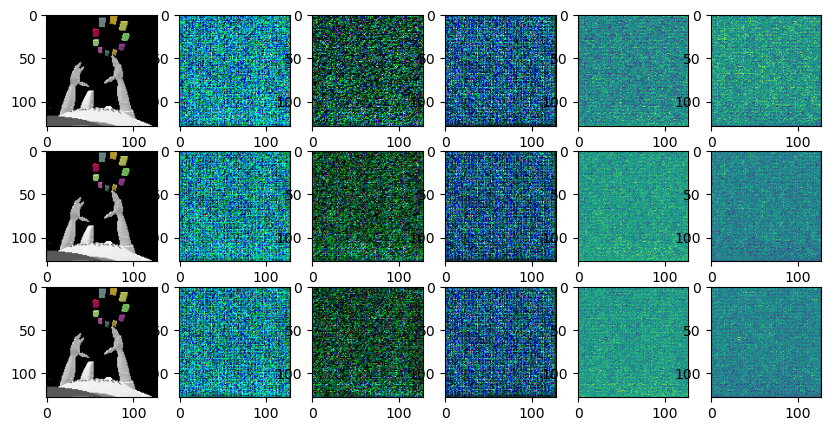

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7387314..4.444151].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6889902..2.1553023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2602947..4.963083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.09603..5.114895].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.226442..3.274781].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.612734..5.652683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.916216..4.27578

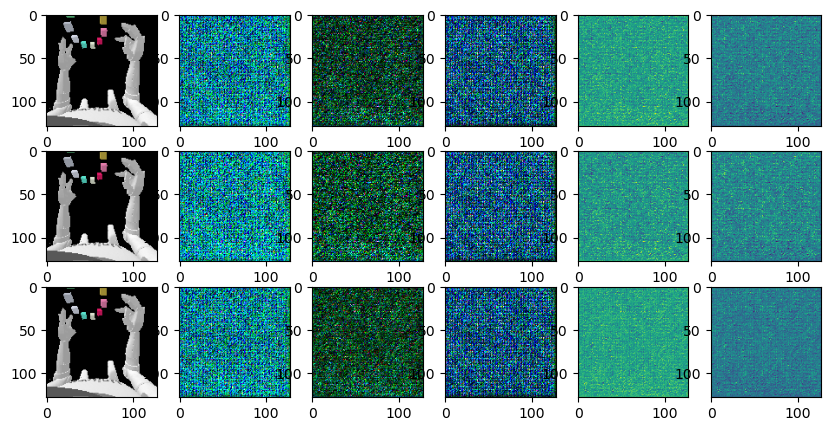

600 Err Tr:  tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])
600 Err Te:  tensor([0.2283, 0.2249, 0.2399, 0.0000, 0.1449, 0.2288])
600 Cosines:  tensor([0.7249, 0.6072, 0.1150])
600 ACC:  tensor([0.6869, 0.0397, 0.6976, 0.0396, 0.6563, 0.0398])
600 PREDICTIVE
Err Test:  tensor([0.2291, 0.2290, 0.2338, 0.2410, 0.2456])
Err Test:  tensor([0.1526, 0.5028, 0.4315, 0.4492, 0.4989])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7485852..4.177643].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.868056..2.6724222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5005424..5.4010987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7771848..4.233984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8968089..2.6068144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5599966..5.393388].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7824348..4

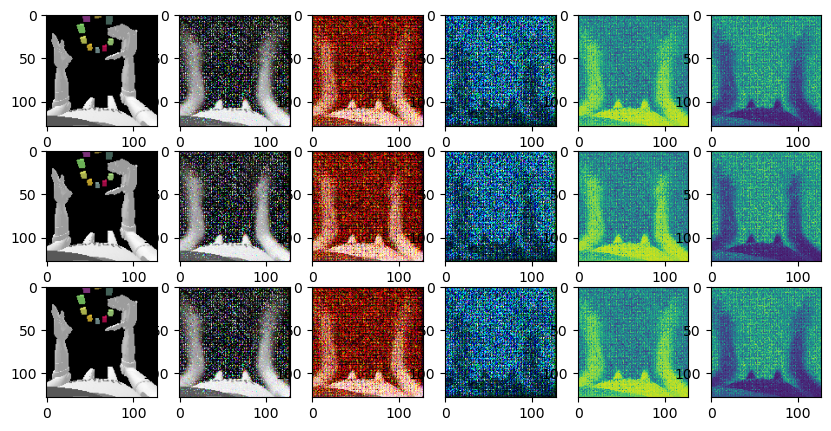

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8085696..4.2878537].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0504181..2.6164105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6062875..5.465139].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7744267..4.1791296].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9606097..2.6174514].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5661926..5.388212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.693953..

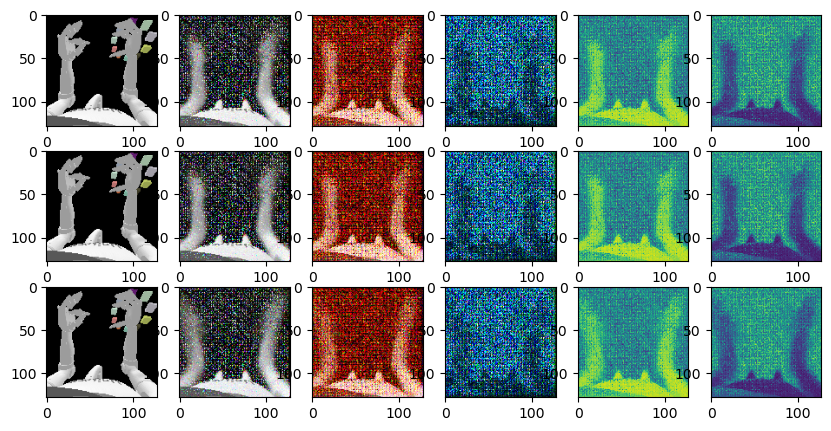

KeyboardInterrupt: 

In [13]:
SETTINGS=[0.5]
eta_consistency=SETTINGS[inp]

import torch.nn.functional as F

SAVE=False
PLOT=True
PRO=1

LOAD=False

if LOAD:

    self_model=torch.load('../Varying_penalty/1/Model_VaryingPenalty_after_corr_0.0_Rep_1_Include_Other_False.pt')
    #self_model=torch.load('./Model_BPTT.pt')
    self_model.Override_Predictive(F_Ns, dt, lr=0.001)
    

N_log=100

N_train1=10000
N_checks1=np.unique(np.int32(np.exp(np.linspace(0,np.log(N_train1),N_log))))

N_train2=50000
N_checks2=np.unique(np.int32(np.exp(np.linspace(0,np.log(N_train2),N_log))))+N_train1
N_checks=np.concatenate([N_checks1, N_checks2],0)
N_train=N_train1+N_train2

N_checks=np.arange(0,101)*600#+10000

N_check=N_checks.shape[0]

ind_help=0

T_decode=5
MSE_Train=torch.zeros([2,N_train,T_decode])
MSE_Tr=torch.zeros([2,N_check,T_decode])

MSE_Te=torch.zeros([2,N_check,T_decode])

MSE_Te_corr=torch.zeros([6,N_check])
ACC_Te=torch.zeros([6,N_check])
Cosines=torch.zeros([3,N_check])

batch_size=32
ind_help=0


for k in range(0,N_train1+N_train2):

    
    X_b, Y_b, A_b, x0s, t0s=Data.Batch_ODE(batch_size, T_horizon=50)
    
    recon_loss1, pro_loss1, z_self, z_other, \
        img, img_self, img_other, mask_self, mask_other=self_model.Predictive_forward(X_b, Y_b, A_b, t0s, n=k, T_decode=5)

        
    MSE_Train[0,k,:]=recon_loss1.detach()
    MSE_Train[1,k,:]=pro_loss1.detach()
   
    if np.any(k==N_checks):
        
        if k>0:
            
            mse_mean=torch.mean(MSE_Train[:,k-N_checks[ind_help-1]:k,:],1)
        
            MSE_Tr[:,ind_help,:]=mse_mean
            
        else:
            
            MSE_Tr[:,ind_help,:]=MSE_Train[:,k,:]
        
        x_b, y_b, lab=Data.Evaluate(batch_size*10)
        X_te, Y_te, A_te, x0s, t0s, lab_=Data.Evaluate_ODE(batch_size, T_horizon_val=3)

        recon_loss_mixed, recon_loss_visual, recon_loss_pro, joint_loss, recon_pro_loss, consistency_loss, \
        acc_self_mixed, acc_other_mixed, acc_self_pro, acc_other_pro, acc_self_visual, acc_other_visual, \
        img_mixed, img_self_mixed, img_other_mixed, mask_self_mixed, mask_other_mixed, \
        img_visual, img_self_visual, img_other_visual, mask_self_visual, mask_other_visual, \
        img_pro, img_self_pro, img_other_pro, mask_self_pro, mask_other_pro, \
        cosine_mixed, cosine_visual, cosine_pro = self_model.Correlation_Eval(x_b, y_b, X_te, Y_te, A_te, x0s, t0s, k, lab, TRAIN=False, PRO=PRO)
        
        MSE_Te_corr[0,ind_help]=recon_loss_mixed.detach()
        MSE_Te_corr[1,ind_help]=recon_loss_visual.detach()
        MSE_Te_corr[2,ind_help]=recon_loss_pro.detach()
        MSE_Te_corr[3,ind_help]=joint_loss.detach()
        MSE_Te_corr[4,ind_help]=recon_pro_loss.detach()
        MSE_Te_corr[5,ind_help]=consistency_loss.detach()

        ACC_Te[0,ind_help]=acc_self_mixed
        ACC_Te[1,ind_help]=acc_other_mixed
        ACC_Te[2,ind_help]=acc_self_visual
        ACC_Te[3,ind_help]=acc_other_visual
        ACC_Te[4,ind_help]=acc_self_pro
        ACC_Te[5,ind_help]=acc_other_pro
        
        Cosines[0,ind_help]=cosine_mixed
        Cosines[1,ind_help]=cosine_visual
        Cosines[2,ind_help]=cosine_pro
        
        
        print(k,'Err Tr: ', MSE_Tr[:,ind_help])
        print(k,'Err Te: ', MSE_Te_corr[:,ind_help])
        print(k,'Cosines: ', Cosines[:,ind_help])
        print(k,'ACC: ', ACC_Te[:,ind_help])

        
        ### PREDICTIVE
        T_hor_val=50
        X_te, Y_te, A_te, x0s, t0s, lab_=Data.Evaluate_ODE(batch_size, T_horizon_val=T_hor_val)

        with torch.no_grad(): 
            
            recon_loss1, pro_loss1, z_self, z_other, \
            img, img_self, img_other, mask_self, mask_other=self_model.Predictive_forward(X_te,Y_te,A_te,t0s,n=k,TRAIN=False)

        MSE_Te[0,ind_help,:]=recon_loss1.detach()
        MSE_Te[1,ind_help,:]=pro_loss1.detach()
        

        print(k, 'PREDICTIVE')
        print('Err Test: ', MSE_Te[0,ind_help] )
        print('Err Test: ', MSE_Te[1,ind_help] ) 
        
        
        ind_help+=1

        if SAVE:

            title_model='Model_BPTT_NoPro_0_proLpy.pt'
            title_model='Model_BPTT_Scaffold.pt'
            torch.save(self_model, title_model)

            title_results='Results_BPTT_Scaffold'
            np.savez(title_results, MSE_Train=MSE_Train, MSE_Tr=MSE_Tr, MSE_Te=MSE_Te, MSE_Te_corr=MSE_Te_corr, N_checks=N_checks, Cosines=Cosines, ACC_Te=ACC_Te)
        
        if PLOT:

            for p in range(2):
            
                fig, ax = plt.subplots(3, 6, figsize=(10, 5))
    
                ax[0,0].imshow(x_b[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[0,1].imshow(img_mixed[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[0,2].imshow(img_self_mixed[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[0,3].imshow(img_other_mixed[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[0,4].imshow(mask_self_mixed[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[0,5].imshow(mask_other_mixed[p,0:3].detach().permute(1,2,0).to('cpu'))

    
                ax[1,0].imshow(x_b[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[1,1].imshow(img_visual[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[1,2].imshow(img_self_visual[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[1,3].imshow(img_other_visual[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[1,4].imshow(mask_self_visual[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[1,5].imshow(mask_other_visual[p,0:3].detach().permute(1,2,0).to('cpu'))


                ax[2,0].imshow(x_b[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[2,1].imshow(img_pro[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[2,2].imshow(img_self_pro[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[2,3].imshow(img_other_pro[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[2,4].imshow(mask_self_pro[p,0:3].detach().permute(1,2,0).to('cpu'))
                ax[2,5].imshow(mask_other_pro[p,0:3].detach().permute(1,2,0).to('cpu'))
    
                plt.show()

    


In [16]:
title_model='Model_BPTT.pt'
torch.save(self_model, title_model)

title_results='Results_BPTT'
np.savez(title_results, MSE_Train=MSE_Train, MSE_Tr=MSE_Tr, MSE_Te=MSE_Te, MSE_Te_corr=MSE_Te_corr, N_checks=N_checks, Cosines=Cosines, ACC_Te=ACC_Te)


In [15]:
#title_model='Model_BPTT_NoPro_0Lp.pt'
#torch.save(self_model, title_model)

#title_results='Results_BPTT_NoPro_0Lp'
#np.savez(title_results, MSE_Train=MSE_Train, MSE_Tr=MSE_Tr, MSE_Te=MSE_Te, MSE_Te_corr=MSE_Te_corr, N_checks=N_checks, Cosines=Cosines, ACC_Te=ACC_Te)
